## Import libraries

In [1]:
import requests
from pathlib import Path
from zipfile import ZipFile
import os
import torch
import torchvision
from torchvision.datasets import ImageFolder
import time
import datetime

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

try:
  from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix, BinaryPrecision, BinaryRecall, BinaryF1Score
except:
  !pip install torchmetrics
  from torchmetrics.classification import BinaryAccuracy, BinaryConfusionMatrix, BinaryPrecision, BinaryRecall, BinaryF1Score

from tqdm.auto import tqdm
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from glob import glob

# Log in to your W&B account
try:
  import wandb
except:
  !pip install wandb -qU
  import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

### Ensure deterministic behavior

In [2]:
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

### Device configuration

In [3]:
if torch.backends.cuda.is_built():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
elif torch.backends.mps.is_built():
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cuda'

## Import W&B

In [4]:
wandb.login()
# API Key: 68ff3881ee331f14ff128c98fe849a3cedbd119d

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Create a list of pretrained models
classification_models = torchvision.models.list_models()
models_dict = {i:model for i, model in enumerate(classification_models)}

**Hyper parameter levels**
* model_no - [16: 'efficientnet_b4', 17: 'efficientnet_b5', 19: 'efficientnet_b7',  80: 'resnet18', 82: 'resnet50', 110: 'vgg16',111: 'vgg16_bn', 120: 'wide_resnet50_2']

* epochs - [5, 10, 15, 20]
* batch_size - [2, 4, 8, 16, 32, 64, 128]
* learning_rate - [0.0001, 0.0005, 0.001, 0.005, 0.01]

Naming Convention: M[Level]E[Level]B[Level]L[Level]

Example: M16E5B32LE-4

Format: f'M{config['model_no]}E{config['epochs']}B{config['batch_size']}L{config['learning_rate']}'

In [26]:
# capture a dictionary of hyperparameters with config
config = dict(
    model_no = 80,
    epochs = 10,
    batch_size = 32,
    learning_rate = 0.01,)
print(f'Name of the run: M{config["model_no"]}E{config["epochs"]}B{config["batch_size"]}L{config["learning_rate"]}')

Name of the run: M80E10B32L0.01


In [7]:
def model_pipeline(hyperparameters):

    # tell wandb to get started
    with wandb.init(project="CastingDataCNN", config=hyperparameters):
      # access all HPs through wandb.config, so logging matches execution!
      config = wandb.config

      # make the model, data, and optimization problem
      model, train_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, exp_lr_scheduler, accuracy, confmat, precision, recall, f1score = make(config)
      print(model)

      # and use them to train the model
      results, model_save_path = train(model, train_dataloader, validation_dataloader, criterion, optimizer, accuracy, confmat, precision, recall, f1score, config)

      # Load the best performing model
      loaded_model = model
      loaded_model.load_state_dict(torch.load(model_save_path/ 'M{hyperparameters["model_no"]}E{hyperparameters["epochs"]}B{hyperparameters["batch_size"]}L{hyperparameters["learning_rate"]}.zip'))

      # test its final performance
      test(loaded_model, test_dataloader, criterion, accuracy, confmat, precision, recall, f1score)

      # and Infer based on testdata
      inference(loaded_model, 5, test_dir, test_dataloader, auto_transform)

    return model, results

## Dataset and Dataloaders

### Download the dataset

**github raw link: https://github.com/SreeramKalluri/Casting_ImageClassification/raw/main/casting_data.zip**

In [8]:
link =  Path('https://github.com/SreeramKalluri/Casting_ImageClassification/raw/main/casting_data.zip')
with open(Path.cwd() / link.name, 'wb') as f:
    request = requests.get('https://github.com/SreeramKalluri/Casting_ImageClassification/raw/main/casting_data.zip')
    f.write(request.content)

with ZipFile(Path.cwd() / link.name, 'r') as zip:
    zip.extractall()

data = Path('casting_data')
train_dir = data / 'train'
test_dir = data / 'test'

for dir_path, dir_names, file_names in os.walk(data):
    print(f"There are {len(dir_names)} folders and {len(file_names)} file in the {dir_path}")

There are 2 folders and 1 file in the casting_data
There are 2 folders and 1 file in the casting_data/train
There are 0 folders and 2875 file in the casting_data/train/non-defective
There are 0 folders and 3758 file in the casting_data/train/defective
There are 2 folders and 1 file in the casting_data/test
There are 0 folders and 262 file in the casting_data/test/non-defective
There are 0 folders and 453 file in the casting_data/test/defective


### Datasets

#### Create auto transform

In [9]:
weights = torchvision.models.get_model_weights(models_dict[config['model_no']])
auto_transform = weights.__members__['DEFAULT'].transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [10]:
def get_data(dir, transform, validation = True):
  if not validation:
    dataset = ImageFolder(root = dir,
                          transform = transform)
    return dataset
  else:
    dataset = ImageFolder(root = dir,
                          transform = transform)
    dataset_train, dataset_val = torch.utils.data.random_split(dataset = dataset,
                                                               lengths = [0.9, 0.1])
    return dataset_train, dataset_val

### Dataloaders

In [11]:
def make_loader(dataset, batch_size):
    loader = torch.utils.data.DataLoader(dataset = dataset,
                                         batch_size = batch_size,
                                         shuffle = True,
                                         pin_memory = True)
    return loader

### Load a Pretrained model

In [12]:
def define_model(model_no: int):
  model = torchvision.models.get_model(models_dict[model_no], weights="DEFAULT")
  model.requires_grad_(False)
  if model_no == 16:
    model.classifier[1] = torch.nn.Linear(in_features=1792, out_features=2, bias=True)
  if model_no == 17:
    model.classifier[1] = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
  if model_no == 19:
    model.classifier[1] = torch.nn.Linear(in_features=2560, out_features=2, bias=True)
  if model_no == 82 or model_no == 120:
    model.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
  if model_no == 80:
    model.fc = torch.nn.Linear(in_features=512, out_features=2, bias=True)
  if model_no == 110 or model_no == 111:
    model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2, bias=True)
    # model.fc = torch.nn.Linear(in_features=2048, out_features=2, bias=True)
  return model

In [13]:
def make(config):
    # Make the data
    train_dataset, validation_dataset = get_data(train_dir, auto_transform, validation = True)
    test_dataset = get_data(test_dir, auto_transform, validation = False)
    train_dataloader = make_loader(train_dataset, batch_size=config['batch_size'])
    validation_dataloader = make_loader(validation_dataset, batch_size=config['batch_size'])
    test_dataloader = make_loader(test_dataset, batch_size=config['batch_size'])

    # Make the model
    model = define_model(config['model_no'])
    summary(model,
            input_size = [32, 3, 224, 224],
            col_names = ['input_size','output_size', 'num_params','trainable'],
            col_width = 20,
            row_settings = ['var_names'])
    model.to(device)

    # Make the loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=config['learning_rate'],
                                momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                       step_size=7,
                                                       gamma=0.1)
    accuracy = BinaryAccuracy().to(device)
    confmat = BinaryConfusionMatrix().to(device)
    precision = BinaryPrecision().to(device)
    recall = BinaryRecall().to(device)
    f1score = BinaryF1Score().to(device)
    return model, train_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, exp_lr_scheduler, accuracy, confmat, precision, recall, f1score

## Training

In [14]:
def format_time(start_time, end_time):
    return str(datetime.timedelta(seconds = round(end_time - start_time)))

In [15]:
def log(example_ct, epoch, loss, accuracy, precision, recall, f1score):
    # Where the magic happens
    wandb.log({"epoch": epoch+1,
               "loss": loss.item(),
               "accuracy": accuracy.item(),
               "precision": precision.item(),
               "recall": recall.item(),
               "f1score": f1score.item()}, step=example_ct)

In [16]:
def train(model, train_dataloader, validation_dataloader, criterion, optimizer, accuracy, confmat, precision, recall, f1score, config):
  # Tell wandb to watch what the model gets up to: gradients, weights, and more!
  wandb.watch(model, criterion, log="all", log_freq=10)
  results = {'train_loss': [],
             'train_accuracy': [],
             'train_precision': [],
             'train_recall': [],
             'train_f1score': [],
             'validation_loss': [],
             'validation_accuracy': [],
             'validation_precision': [],
             'validation_recall': [],
             'validation_f1score': []}
  # Run training, validation and track with wandb
  total_batches = len(train_dataloader) * config['epochs']
  example_ct = 0  # number of train examples seen
  batch_ct = 0 # number of train batches seen
  best_loss, best_f1 = 100, 0
  start_time = time.time()
  for epoch in tqdm(range(config['epochs'])):
    # Model Training
    model.train()
    train_loss, train_acc, train_pres, train_recal, train_f1 = 0, 0, 0, 0, 0
    cmt = torch.zeros(len(train_dataloader.dataset.dataset.classes), len(train_dataloader.dataset.dataset.classes))
    for _, (images, labels) in enumerate(train_dataloader):
      loss, acc, cm, pres, recal, f1 = batch(images, labels, model, optimizer, criterion, accuracy, confmat, precision, recall, f1score, gradient = True)
      train_loss += loss.item()
      train_acc += acc.item()
      train_pres += pres.item()
      train_recal += recal.item()
      train_f1 += f1.item()
      cmt += cm.cpu()

    # Model Validation
    model.eval()
    val_loss, val_acc, val_pres, val_recal, val_f1 = 0, 0, 0, 0, 0
    cmv = torch.zeros(len(validation_dataloader.dataset.dataset.classes), len(validation_dataloader.dataset.dataset.classes))
    with torch.inference_mode():
      for _, (images, labels) in enumerate(validation_dataloader):
        loss, acc, cm, pres, recal, f1 = batch(images, labels, model, optimizer, criterion, accuracy, confmat, precision, recall, f1score, gradient = False)
        example_ct +=  len(images)
        batch_ct += 1

        # Report metrics every batch
        log(example_ct, epoch, loss, acc, pres, recal, f1)

        val_loss += loss.item()
        val_acc += acc.item()
        val_pres += pres.item()
        val_recal += recal.item()
        val_f1 += f1.item()
        cmv += cm.cpu()

    # Train results
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_pres /= len(train_dataloader)
    train_recal /= len(train_dataloader)
    train_f1 /= len(train_dataloader)
    results['train_loss'].append(train_loss)
    results['train_accuracy'].append(train_acc)
    results['train_precision'].append(train_pres)
    results['train_recall'].append(train_recal)
    results['train_f1score'].append(train_f1)

    # Validation Results
    val_loss /= len(validation_dataloader)
    val_acc /= len(validation_dataloader)
    val_pres /= len(validation_dataloader)
    val_recal /= len(validation_dataloader)
    val_f1 /= len(validation_dataloader)
    results['validation_loss'].append(val_loss)
    results['validation_accuracy'].append(val_acc)
    results['validation_precision'].append(val_pres)
    results['validation_recall'].append(val_recal)
    results['validation_f1score'].append(val_f1)

    # Model saving @ best configuration
    if best_loss >= val_loss and best_f1 <= val_f1:
        # Create a path to save model
        model_save_path = Path.cwd() / 'saved_model'
        model_save_path.mkdir(parents = True, exist_ok = True)
        print(f"Model Saved during epoch number {epoch+1}")
        best_loss, best_f1 = val_loss, val_f1
        torch.save(model.state_dict(), model_save_path/'M{config["model_no"]}E{config["epochs"]}B{config["batch_size"]}L{config["learning_rate"]}.zip')

    print(f"Epoch: {epoch+1}/{config['epochs']} | Train loss: {train_loss:.3f} | Train_accuracy: {train_acc:.3f} | Train_precision: {train_pres:.3f} | Train_recall: {train_recal:.3f} | Train_f1score: {train_f1:.3f}")
    print(f"Epoch: {epoch+1}/{config['epochs']} | Validation loss: {val_loss:.3f} | Validation_accuracy: {val_acc:.3f} | Validation_precision: {val_pres:.3f} | Validation_recall: {val_recal:.3f} | Validation_f1score: {val_f1:.3f}")
  end_time = time.time()
  print(f"Training time: {format_time(start_time, end_time)}")
  results_df = pd.DataFrame(results)

  # Plotting losses and accuracy
  fig, ax = plt.subplots(3, 2, figsize = (16, 18))
  fig.suptitle('Classification Metrics', fontsize = 24)
  # fig.tight_layout(h_pad = 10)
  # fig.tight_layout(w_pad = 5)

  ax[0,0].plot(results_df['train_loss'], label = 'Train loss')
  ax[0,0].plot(results_df['validation_loss'], label = 'Validation_loss')
  ax[0,0].set_title('Loss')
  ax[0,0].set_xlabel('epoch no.')
  ax[0,0].set_ylabel('loss')
  ax[0,0].legend()

  ax[0,1].plot(results_df['train_accuracy'], label = 'Train accuracy')
  ax[0,1].plot(results_df['validation_accuracy'], label = 'Validation accuracy')
  ax[0,1].set_title('Accuracy')
  ax[0,1].set_xlabel('epoch no.')
  ax[0,1].set_ylabel('accuracy')
  ax[0,1].legend()

  ax[1,0].plot(results_df['train_precision'], label = 'Train precision')
  ax[1,0].plot(results_df['validation_precision'], label = 'Validation precision')
  ax[1,0].set_title('Precision')
  ax[1,0].set_xlabel('epoch no.')
  ax[1,0].set_ylabel('precision')
  ax[1,0].legend()

  ax[1,1].plot(results_df['train_recall'], label = 'Train recall')
  ax[1,1].plot(results_df['validation_recall'], label = 'Validation recall')
  ax[1,1].set_title('Recall')
  ax[1,1].set_xlabel('epoch no.')
  ax[1,1].set_ylabel('recall')
  ax[1,1].legend()

  ax[2,0].plot(results_df['train_f1score'], label = 'Train f1score')
  ax[2,0].plot(results_df['validation_f1score'], label = 'Validation f1score')
  ax[2,0].set_title('F1-score')
  ax[2,0].set_xlabel('epoch no.')
  ax[2,0].set_ylabel('f1score')
  ax[2,0].legend()

  fig, axes = plt.subplots(1, 2, figsize=(16, 6))
  fig.suptitle('Confusion Matrices', fontsize = 24)
  fig.tight_layout(w_pad=15)
  axes[0].set_title("Training")
  ConfusionMatrixDisplay(confusion_matrix=cmt.cpu().numpy(), display_labels=train_dataloader.dataset.dataset.classes).plot(include_values=True, cmap="Blues", ax=axes[0], colorbar=False, values_format='.0f')
  axes[1].set_title("Validation")
  ConfusionMatrixDisplay(confusion_matrix=cmv.cpu().numpy(), display_labels=train_dataloader.dataset.dataset.classes).plot(include_values=True, cmap="Blues", ax=axes[1], colorbar=False, values_format='.0f')
  return results_df, model_save_path


def batch(images, labels, model, optimizer, criterion, accuracy, confmat, precision, recall, f1score, gradient = True):
    images, labels = images.to(device), labels.to(device)

    if gradient:
      model.train()
      # Forward pass ➡
      preds = model(images)
      loss = criterion(preds, labels)
      acc = accuracy(preds.softmax(dim = -1).argmax(dim = -1), labels)
      cm = confmat(preds.softmax(dim = -1).argmax(dim = -1), labels)
      pres = precision(preds.softmax(dim = -1).argmax(dim = -1), labels)
      recal = recall(preds.softmax(dim = -1).argmax(dim = -1), labels)
      f1 = f1score(preds.softmax(dim = -1).argmax(dim = -1), labels)
      # Backward pass ⬅
      optimizer.zero_grad()
      loss.backward()
      # Step with optimizer
      optimizer.step()
    else:
      model.eval()
      with torch.inference_mode():
        # Forward pass ➡
        preds = model(images)
        loss = criterion(preds, labels)
        acc = accuracy(preds.softmax(dim = -1).argmax(dim = -1), labels)
        cm = confmat(preds.softmax(dim = -1).argmax(dim = -1), labels)
        pres = precision(preds.softmax(dim = -1).argmax(dim = -1), labels)
        recal = recall(preds.softmax(dim = -1).argmax(dim = -1), labels)
        f1 = f1score(preds.softmax(dim = -1).argmax(dim = -1), labels)

    return loss, acc, cm, pres, recal, f1

## Testing

In [17]:
# Testing using loaded model
def test(model, test_dataloader, criterion, accuracy, confmat, precision, recall, f1score):
  model.eval()
  with torch.inference_mode():
    test_loss, test_acc, test_pres, test_recal, test_f1 = 0, 0, 0, 0, 0
    cmtt = torch.zeros(len(test_dataloader.dataset.classes), len(test_dataloader.dataset.classes))
    for images, labels in tqdm(test_dataloader):
      images, labels = images.to(device), labels.to(device)
      tpreds = model(images)
      tloss = criterion(tpreds, labels)
      test_loss += tloss.item()
      tacc = accuracy(tpreds.softmax(dim = -1).argmax(dim = -1), labels)
      test_acc += tacc.item()
      cmt = confmat(tpreds.softmax(dim = -1).argmax(dim = -1), labels)
      cmtt += cmt.cpu()
      tpres = precision(tpreds.softmax(dim = -1).argmax(dim = -1), labels)
      test_pres += tpres.item()
      trecal = recall(tpreds.softmax(dim = -1).argmax(dim = -1), labels)
      test_recal += trecal.item()
      tf1 = f1score(tpreds.softmax(dim = -1).argmax(dim = -1), labels)
      test_f1 += tf1.item()

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    test_pres /= len(test_dataloader)
    test_recal /= len(test_dataloader)
    test_f1 /= len(test_dataloader)

  print(f"Test loss: {test_loss:.3f} | Test_accuracy: {test_acc:.3f} | Test_precision: {test_pres:.3f} | Test_recall: {test_recal:.3f} | Test_f1score: {test_f1:.3f}")
  cmd = ConfusionMatrixDisplay(confusion_matrix=cmtt.cpu().numpy(), display_labels=test_dataloader.dataset.classes)
  cmd.plot(include_values=True, cmap="Blues", colorbar=False, values_format='.0f')
  cmd.ax_.set(title = 'Testing')

  wandb.log({"test_loss": test_loss,
               "test_accuracy": test_acc,
               "test_precision": test_pres,
               "test_recall": test_recal,
               "test_f1score": test_f1})
  return test_loss, test_acc, test_pres, test_recal, test_f1

## Inference

In [18]:
def inference(model, nsample, image_dir, image_dataloader, transform):
  start_time = time.time()
  test_image_list = list(test_dir.glob("*/*.jpeg"))
  test_image_path = random.sample(test_image_list, k = nsample)
  fig = plt.figure(figsize= (18, 7*(nsample//3)+1))
  fig.suptitle('Inference', fontsize = 21)
  plt.subplots_adjust(hspace=0.3)
  for i in range (nsample):
    ax = fig.add_subplot((nsample//3)+1, 3, i+1)
    custom_image = torchvision.io.read_image(str(test_image_path[i]))
    transformed_image = auto_transform(custom_image)
    model.eval()
    with torch.inference_mode():
      pred = model(transformed_image.unsqueeze(0).to(device))
    ax.imshow(np.asarray(Image.open(test_image_path[i])))
    title = f"Pred: {image_dataloader.dataset.classes[pred.softmax(dim=-1).argmax(dim=-1).cpu()]} | Label: {test_image_path[i].parent.name}"
    ax.set_title(title)
    end_time = time.time()
  return format_time(start_time, end_time)

## Build, Train and Analyze the model with the pipeline

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

  0%|          | 0/10 [00:00<?, ?it/s]

Model Saved during epoch number 1
Epoch: 1/10 | Train loss: 0.180 | Train_accuracy: 0.923 | Train_precision: 0.911 | Train_recall: 0.910 | Train_f1score: 0.899
Epoch: 1/10 | Validation loss: 0.044 | Validation_accuracy: 0.985 | Validation_precision: 0.979 | Validation_recall: 0.990 | Validation_f1score: 0.984
Epoch: 2/10 | Train loss: 0.078 | Train_accuracy: 0.971 | Train_precision: 0.965 | Train_recall: 0.974 | Train_f1score: 0.966
Epoch: 2/10 | Validation loss: 0.099 | Validation_accuracy: 0.964 | Validation_precision: 0.928 | Validation_recall: 1.000 | Validation_f1score: 0.962
Model Saved during epoch number 3
Epoch: 3/10 | Train loss: 0.064 | Train_accuracy: 0.979 | Train_precision: 0.971 | Train_recall: 0.983 | Train_f1score: 0.975
Epoch: 3/10 | Validation loss: 0.033 | Validation_accuracy: 0.990 | Validation_precision: 0.981 | Validation_recall: 0.997 | Validation_f1score: 0.989
Model Saved during epoch number 4
Epoch: 4/10 | Train loss: 0.045 | Train_accuracy: 0.985 | Train_pre

  0%|          | 0/23 [00:00<?, ?it/s]

Test loss: 0.031 | Test_accuracy: 0.992 | Test_precision: 0.977 | Test_recall: 1.000 | Test_f1score: 0.987


accuracy,▁███▃▆█▃██▆▆█▆████████▆███████████▆█████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
f1score,▁███▄▆█▄██▆▆█▆████████▅███████████▆█████
loss,▆▂▂▁▅▄▂▄▁▂▂█▁▄▂▁▂▁▂▁▁▁▅▁▁▂▁▂▁▁▁▁▁▁▅▁▁▁▁▁
precision,▁███▂▅█▂██▅▅█▅████████▄███████████▅█████
recall,▁███████████████████████████████████████
test_accuracy,▁
test_f1score,▁
test_loss,▁
test_precision,▁
test_recall,▁


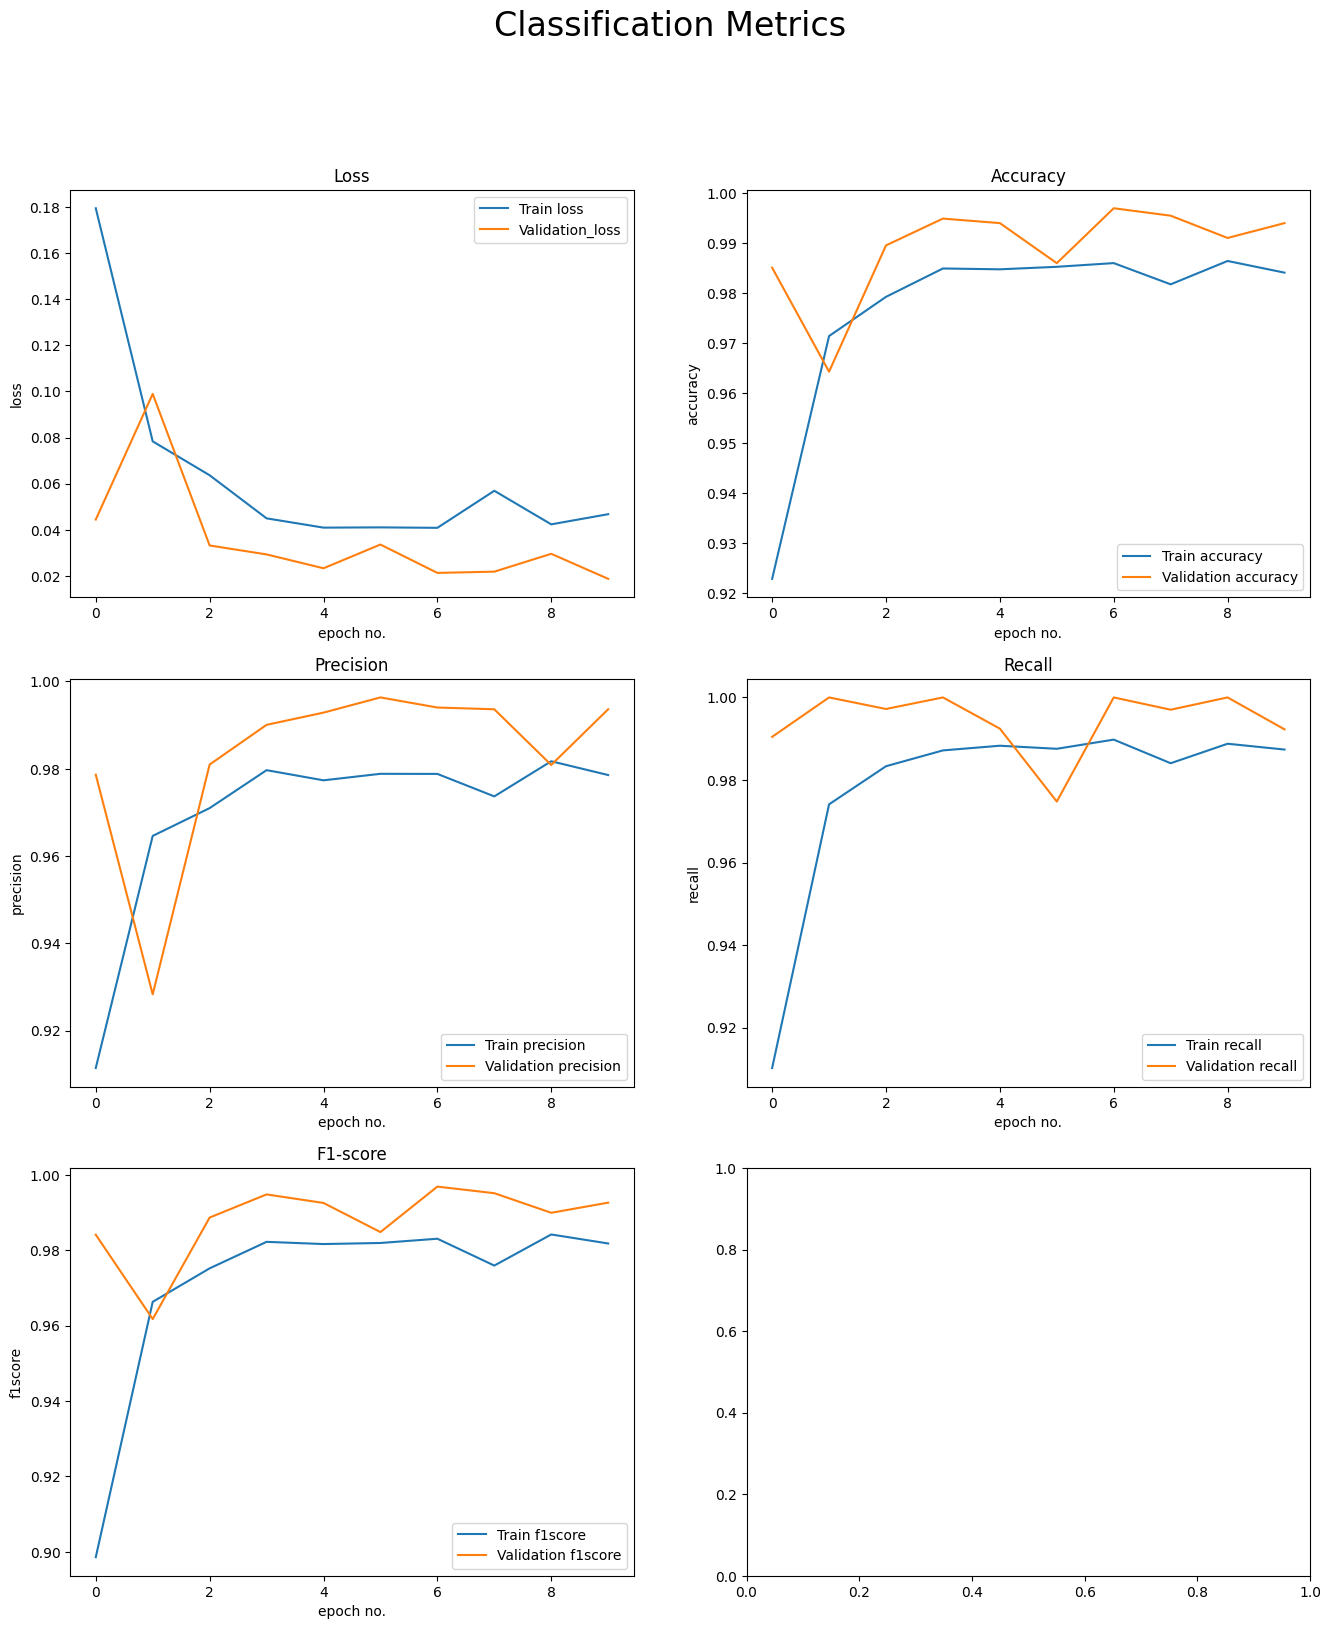

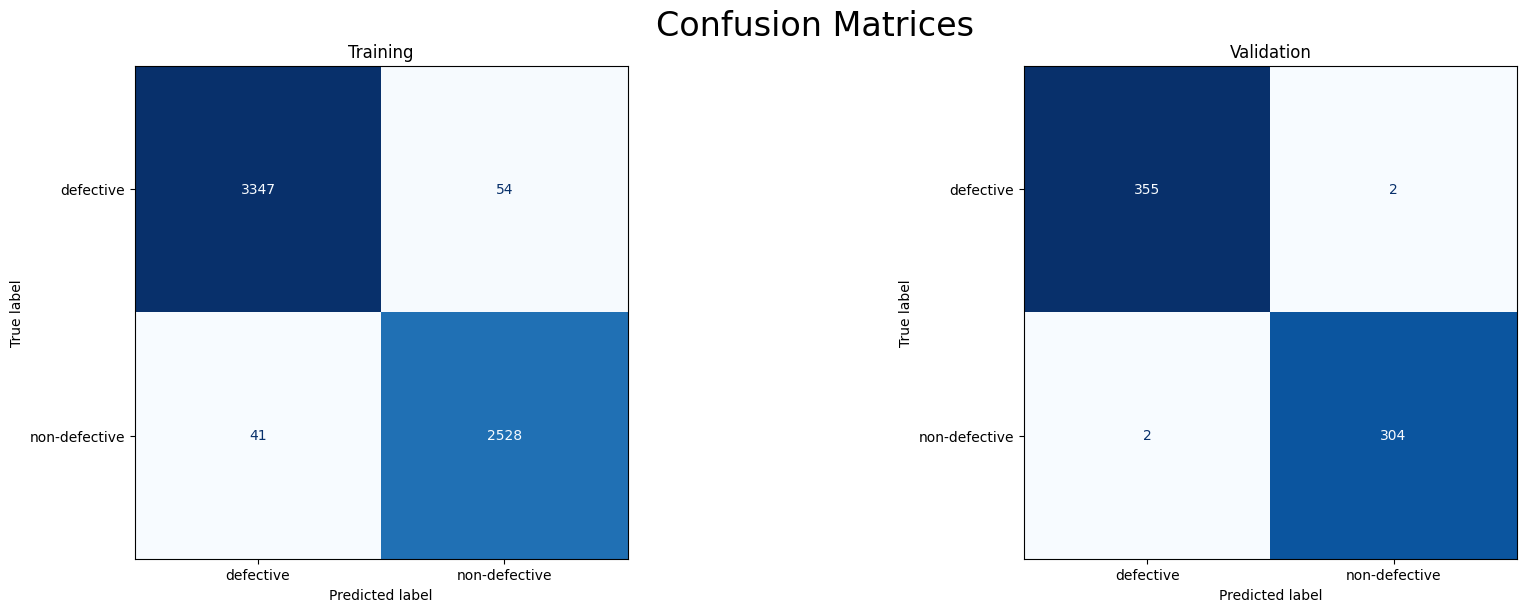

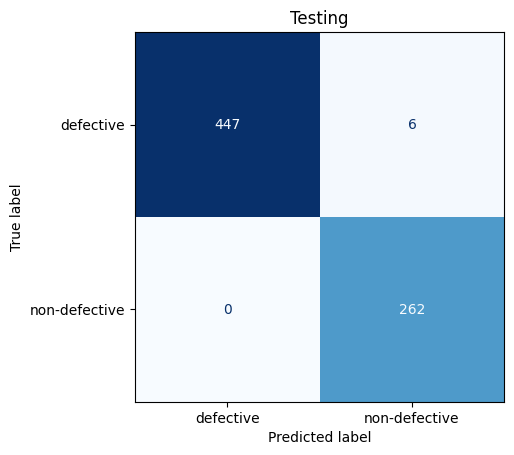

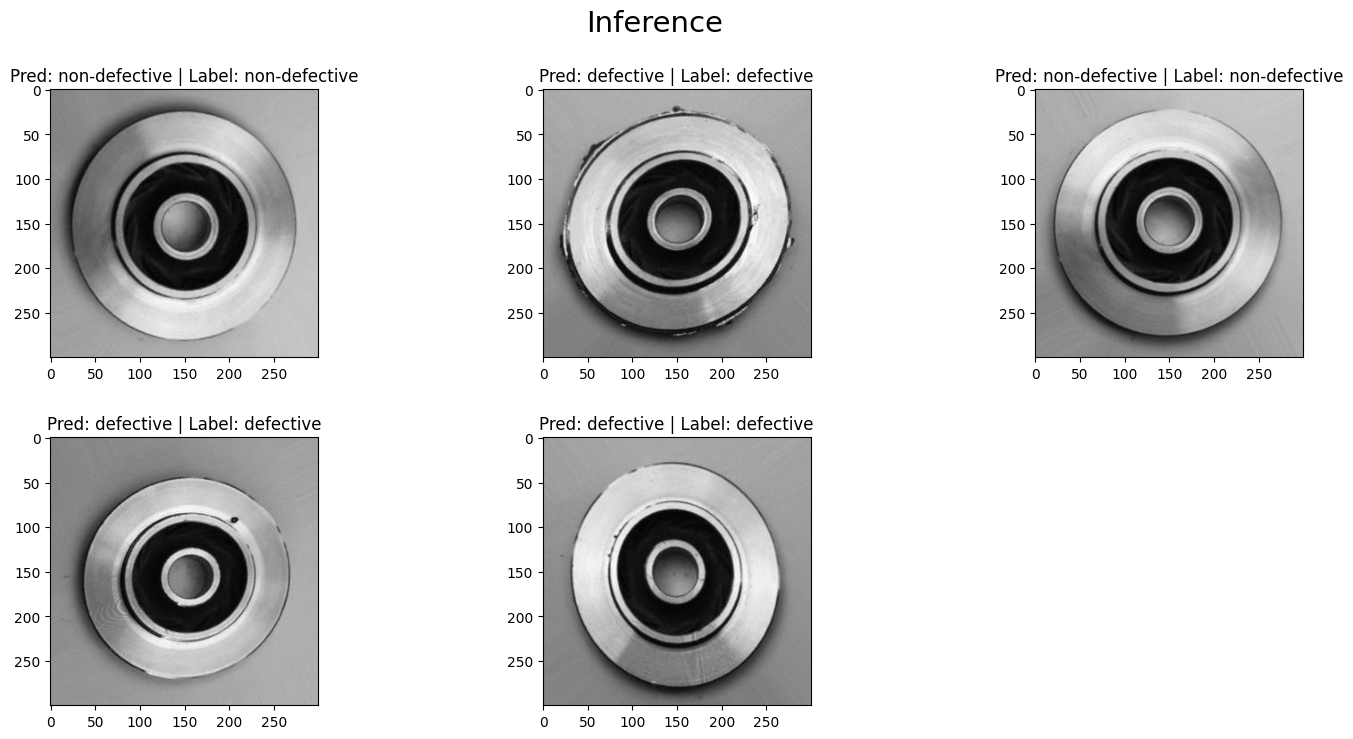

In [27]:
model = model_pipeline(config)

## Export saved model to drive

In [31]:
from google.colab import drive
drive.mount('/content/drive')

import locale
locale.getpreferredencoding = lambda: "UTF-8"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!ls -l --block-size=K ./saved_model/
!ls -l --block-size=M ./saved_model/'M{config["model_no"]}E{config["epochs"]}B{config["batch_size"]}L{config["learning_rate"]}.zip'
!cp ./saved_model/'M{config["model_no"]}E{config["epochs"]}B{config["batch_size"]}L{config["learning_rate"]}.zip' /content/drive/MyDrive

total 87488K
-rw-r--r-- 1 root root 43741K Apr  2 11:11 M80E10B32L0.01.zip
-rw-r--r-- 1 root root 43741K Apr  2 10:59 M80E10B64L0.0105.zip
-rw-r--r-- 1 root root 43M Apr  2 11:11 ./saved_model/M80E10B32L0.01.zip


In [33]:
f'M{config["model_no"]}E{config["epochs"]}B{config["batch_size"]}L{config["learning_rate"]}'

'M80E10B32L0.01'